# Importing 

In [261]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re


In [262]:
from sklearn.linear_model import Ridge, Lasso, RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

In [263]:
pd.set_option('display.max_rows', None)

#### Ideas:
1. Cluster neighborhoods by proportion of stablishments per industry sector. It can also be done for proportion of energy consumption per type.

2. Cluster Neighborhoods By correlation of energy consumption categories with year. Result: Neighborhoods profiles of energy consumption variation tendency for each category
Idea: Cluster Neighborhoods By coefficients of regressiong of total consumption per consumption per category. You can also do it for industry sector. Result: Neighborhoods profiles of category consumption impact.


# Loading Extended Time Series

In [264]:
time = pd.read_csv('\\Users\luisr\Desktop\Repository\IBM_courses\Course Work\Assignments\Final Capstone Project\\rio dataframes\\Outside Data\\raw\\bairros\\timeserie_energia_economia_extended.csv')

# Economic Correlation Analysis

In [122]:
i=-1

In [ ]:
#i+=1
print(i, time[cols[1]][i])
anos = time[time[cols[1]]==time[cols[1]][i]][['Ano']+targets].apply(np.log1p).corr()['Ano']
anos_abs_index = np.abs(anos).sort_values(ascending=False).index
anos_corr = anos.reindex(anos_abs_index).to_frame().reset_index()
anos_corr
#sns.heatmap(data=np.asarray(anos), cmap='RdBu', linewidths=0.5)

In [ ]:
fig = plt.figure(figsize=(25,25))              # Entire Set Correlation Analysis
ax0 = fig.add_subplot(111)

sns.heatmap(time.corr(), linewidths=0.5, cmap='RdBu', ax=ax0)

#### We can see how strongly correlated features in this dataset are. This can have many causes. A simple explanation for this is that neighborhoods with higher areas tend to have either higher economic activity and higher energy consumption in general. Therefore an increase in energy consumption of any type or in activities of any economic sector in a given neighborhood is associated with an increase on the other consumption types or economic sectors.

# Cleaning

In [265]:
time.dropna(how='all', inplace=True, axis=1)

In [266]:
for col in time.columns[2:]: time[col] = time[col].fillna(time[col].mean())

# Feature Selection

### Note: Remember to Fill missing values with means of same neighborhood

In [267]:
targets = ['Consumo de energia elétrica (MWh)', 'Residencial_x',        # Energy related variables
       'Industrial_x', 'Comercial', 'Rural_x', 'Poder público ',
       'Iluminacão pública', 'Serv.público_x', 'Consumo próprio_x',
       'Consumo resdencial de energia elétrica (MWh)',
       'Médio anual por unidade consumidora  ',
       'Total de unidades consumidoras  residenciais ', 'Total_y.1',
       'Residencial_y', 'Industrial_y', 'Comercial ', 'Rural_y',
       'Poderes públicos ', 'Iluminação pública', 'Serv.público_y',
       'Consumo próprio_y']

In [268]:
i=-1

In [272]:
i+=1
target = targets[i]
print(i, target)

3 Comercial


In [273]:
cols_df = pd.DataFrame(time.columns)

### X & Y:

In [279]:
x = time.drop(targets, axis=1).iloc[:, 2:].dropna(how='all', axis=1).copy()

In [280]:
y = time[[target]].copy()

### Log Transformation

In [281]:
y = y.apply(np.log1p)

In [282]:
x = x.apply(np.log1p)

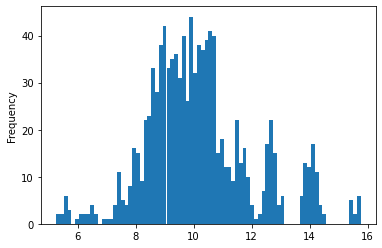

In [283]:
y[target].plot(kind='hist', bins=80)

### Idea: Categorize residential energy consumption, predict using classification algorithms, interpret. The presence and salary of what sectors determine the residential energy consumption division? What sectors are in or are paying in each division?
### Cluster neighborhoods by residential energy consumption, compare means of each year between groups. This would be a time-series plot of the means of each cluster.

# Normalization

In [284]:
scaler = MinMaxScaler()
x_norm = scaler.fit_transform(x)
y_norm = scaler.fit_transform(y)

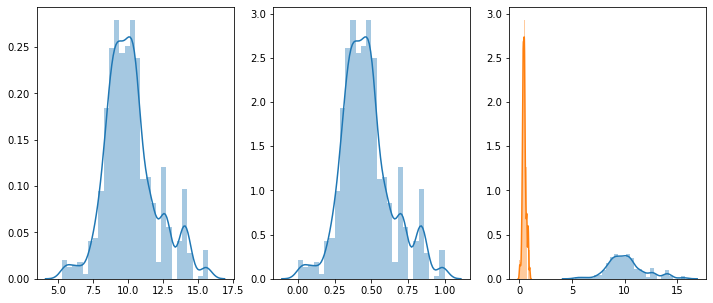

In [285]:
fig = plt.figure(figsize=(12, 5))
ax0=fig.add_subplot(1, 3, 1)
ax1=fig.add_subplot(1, 3, 2)
ax2=fig.add_subplot(1, 3, 3)

sns.distplot(y, ax=ax0)
sns.distplot(y_norm.ravel(), ax=ax1)
sns.distplot(y, ax=ax2)
sns.distplot(y_norm.ravel(), ax=ax2)


x_norm = StandardScaler().fit_transform(x)
y_norm = StandardScaler().fit_transform(y)

# Polynomial Transformation

In [286]:
#x_poly_norm = PolynomialFeatures(degree=3).fit_transform(x_norm)

In [287]:
#x_poly = PolynomialFeatures(degree=2, include_bias=False).fit_transform(x)

In [288]:
#x_poly_norm.shape, x.shape

# Ridge Regression

### Idea: Run clusterization of neighborhoods by most influential economic sectors

In [289]:
scrs=[]
for i in range(500): 
    
    msk = np.random.rand(len(y))<0.8
    x_train, y_train, x_test, y_test = x_norm[msk], y_norm[msk], x_norm[~msk], y_norm[~msk]

# Regression

    ridge = Ridge(alpha=0.6)
    ridge.fit(x_train, y_train)
    
    #y_pred = ridge.predict(x_test)
    y_pred = np.expm1(scaler.inverse_transform(ridge.predict(x_test)))
    y_test = np.expm1(scaler.inverse_transform(y_test))
    
# Evaluation

    scrs.append(r2_score(y_test, y_pred))

#### Note: Update to Histogram

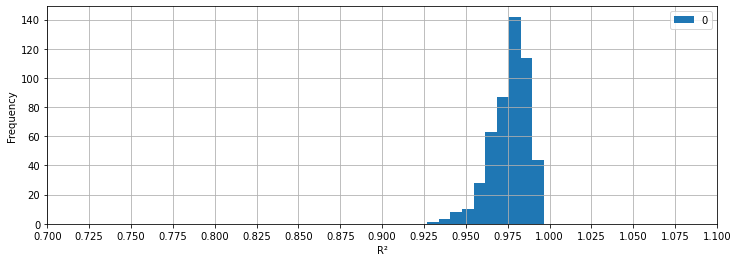

In [290]:
pd.DataFrame(scrs).plot(kind='hist', figsize=(12, 4), xticks=np.arange(0.7, 1.1, 0.025))
plt.xlabel('R²')
#plt.xticks(np.linspace(-3.4, 2.4, 30))
plt.grid()

In [291]:
coefs = ridge.coef_

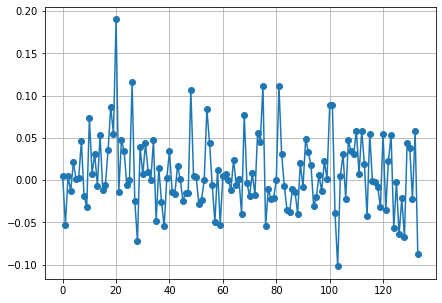

In [292]:
coefs_df = pd.Series(coefs.ravel())
coefs_df.plot(marker='o', figsize=(7,5))
plt.xticks()
plt.grid()

### Note: Try out aligned coefficients plot

# Conclusion: Highly integrated, having contributions from most features. Exposes the high interconnetivity between local economic factors and energy consumption levels.

Is already possible to discern a few sectors that impact comercial energy consumption the most. We can see that there are well distributed levels of impact of the different sectors in energy consumption level (That is, different sectors of the economy impact the energy consumption of the neighborhoods in several different magnitude levels). But it is still not clear wether there is some pattern across these impacts.

In [293]:
len(coefs_df)

134

In [294]:
high_coefs = []
coefs_values = []

for i in range(len(coefs_df)):
    if np.abs(coefs.ravel()[i])>.1: 
        high_coefs.append(i)
        coefs_values.append(coefs.ravel()[i])
        
coefs_sorted = pd.DataFrame(coefs_values, index=x.iloc[:, high_coefs].columns).sort_values(by=0, ascending=False)

In [295]:
high_coefs

[20, 26, 48, 75, 81, 103]

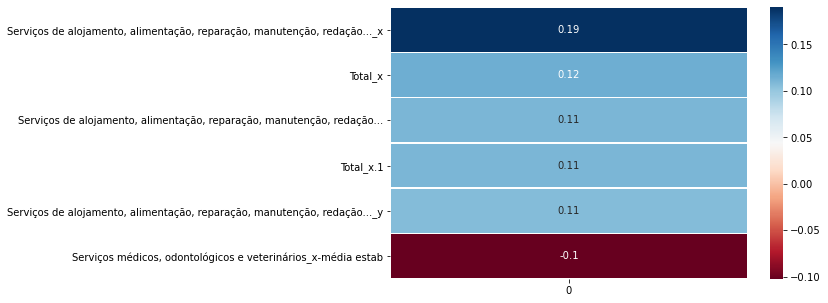

In [296]:
ax = plt.figure(figsize=(8,5))
ax0 = ax.add_subplot(111)
sns.heatmap(coefs_sorted, ax=ax0, annot=True, linewidths=0.5, cmap='RdBu')


# Conclusion: We can see that a negative predictor was spotted. Where average salaries are lower, there is more comercial energy consumption and vice-versa. This can be an indication that more ecomercial activity b along with lower salaries, resulting in higher comercial energy consumption matching lower salaries in location. This can be checked plotting the sallaries

## Note: Add to report rection explaining why various different combinations of features and coefficients might lead to a precise prediction. Relate that to the fatc that energy consumption is deeply ingrained to economic factors and how that opens space for different interpretation of the models results (for example the inverse relation between lower abg salary and energy consumption.

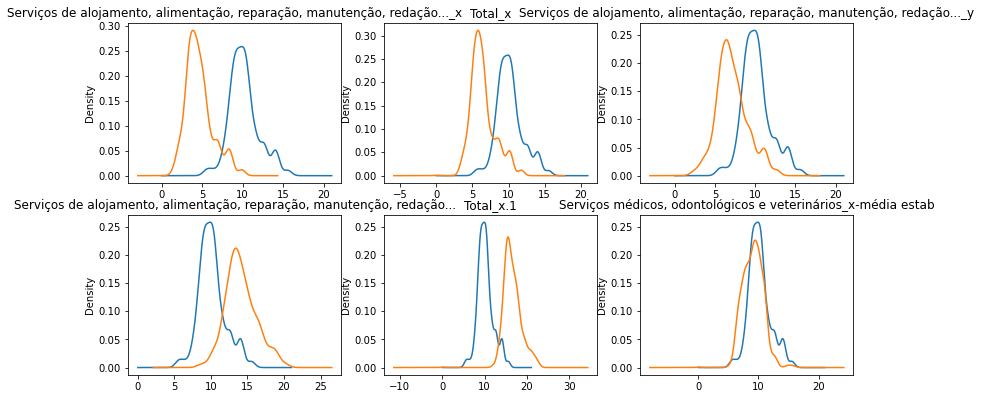

In [297]:
fig = plt.figure(figsize=(13, 10))

axes = [fig.add_subplot((len(high_coefs) if len(high_coefs)//3==0 else int(len(high_coefs)/3+1)), 3,  i+1) for i in range(len(high_coefs))]

for i in range(len(high_coefs)): 
    y[target].plot(kind='kde', ax=axes[i])
    x[x.columns[high_coefs[i]]].plot(kind='kde', ax=axes[i])
    axes[i].set_title(x.columns[high_coefs[i]])

#sns.kdeplot(y[target], ax=ax0)
#sns.kdeplot(x[x.columns[high_coefs[0]]], ax=ax0, bw=5) 

#y[target].plot(kind='kde', ax=ax0)
#x[x.columns[high_coefs[7]]].plot(kind='kde', ax=ax0)

# Lasso

In [298]:
scrs= []
for i in range(500):
    
    msk = np.random.rand(len(y_norm))<0.8
    x_train, y_train, x_test, y_test = x_norm[msk], y_norm[msk], x_norm[~msk], y_norm[~msk]
    
    lasso = Lasso(alpha=0.00052).fit(x_train, y_train)

    #y_pred = lasso.predict(x_test)
    y_pred = np.expm1(scaler.inverse_transform(ridge.predict(x_test)))
    y_test = np.expm1(scaler.inverse_transform(y_test))

    scrs.append(r2_score(y_test, y_pred))
    

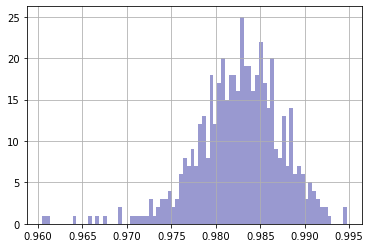

In [299]:
sns.distplot(scrs, kde=False, bins=80, color='darkblue')
plt.grid()

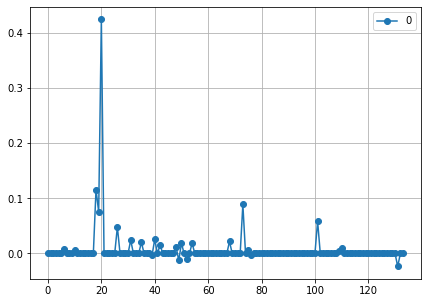

In [300]:
coefs_df = pd.DataFrame(lasso.coef_)
coefs_df.plot(marker='o', figsize=(7,5))
plt.xticks()
plt.grid()

In [301]:
coefs = lasso.coef_

In [302]:
high_coefs = []
coefs_values = []

for i in range(len(coefs_df)):
    if np.abs(coefs.ravel()[i])>0.05:
        
        high_coefs.append(i)
        coefs_values.append(coefs.ravel()[i])
        
coefs_sorted = pd.DataFrame(coefs_values, index=x.iloc[:, high_coefs].columns).sort_values(by=0, ascending=False)

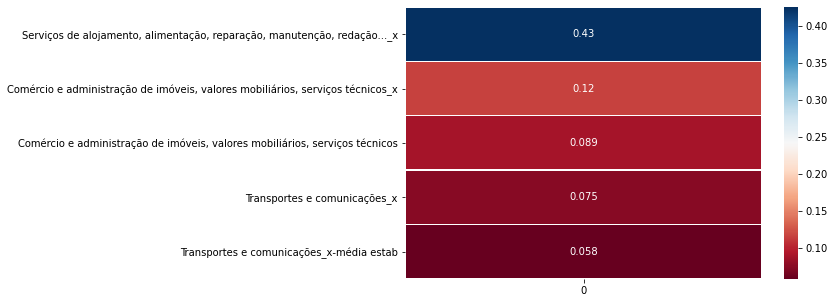

In [303]:
ax = plt.figure(figsize=(8,5))
ax0 = ax.add_subplot(111)
sns.heatmap(coefs_sorted, ax=ax0, annot=True, linewidths=0.5, cmap='RdBu')


### Conclusion: Neighborhoods where Communication and transport sectors are spending more with work force, consume more energy, as well as neighborhoods where there are more stablishments of the immobiliary sector. This  means neighborhoods with lots of comercial activity. For example, downtowns and comercial neighborhoods likely contains more stablishments from the immobiliary sector due to the high number of immobiliary transactions in these neighborhoods. The same goes for work force money spending in transport end communication. As these neighborhoods present high foot-traffic or people-flow, more money is spent in transportation and communication in these areas, by the sector companies.

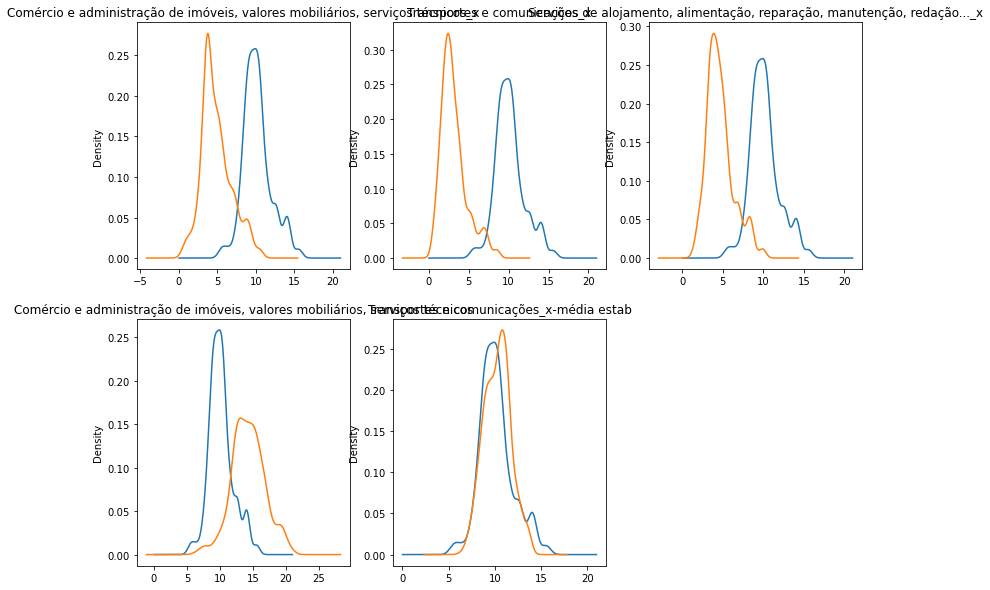

In [304]:
fig = plt.figure(figsize=(13, 10))

axes = [fig.add_subplot((len(high_coefs) if len(high_coefs)//3==0 else int(len(high_coefs)/3+1)), 3,  i+1) for i in range(len(high_coefs))]

for i in range(len(high_coefs)): 
    y[target].plot(kind='kde', ax=axes[i])
    x[x.columns[high_coefs[i]]].plot(kind='kde', ax=axes[i])
    axes[i].set_title(x.columns[high_coefs[i]])

#sns.kdeplot(y[target], ax=ax0)
#sns.kdeplot(x[x.columns[high_coefs[0]]], ax=ax0, bw=5) 

#y[target].plot(kind='kde', ax=ax0)
#x[x.columns[high_coefs[7]]].plot(kind='kde', ax=ax0)

# Ridge Cross-Validation

In [305]:
alphas = np.linspace(0.001, 2, 200)

In [306]:
scrs = []
for i in range(30):

    msk = np.random.rand(len(y))<0.8
    x_train, y_train, x_test, y_test = x_norm[msk], y_norm[msk], x_norm[~msk], y_norm[~msk]

    
    ridge_cv = RidgeCV(alphas=alphas, cv=4)
    ridge_cv.fit(x_train, y_train)

    #y_pred = ridge_cv.predict(x_test)

    y_pred = np.expm1(scaler.inverse_transform(ridge_cv.predict(x_test).reshape(-1, 1)))
    y_test = np.expm1(scaler.inverse_transform(y_test))

    scrs.append([r2_score(y_test, y_pred), ridge_cv.alpha_, ridge_cv.best_score_])
                
    if i in range(0, 500, 4): print(i, 'complete')

0 complete
4 complete
8 complete
12 complete
16 complete
20 complete
24 complete
28 complete


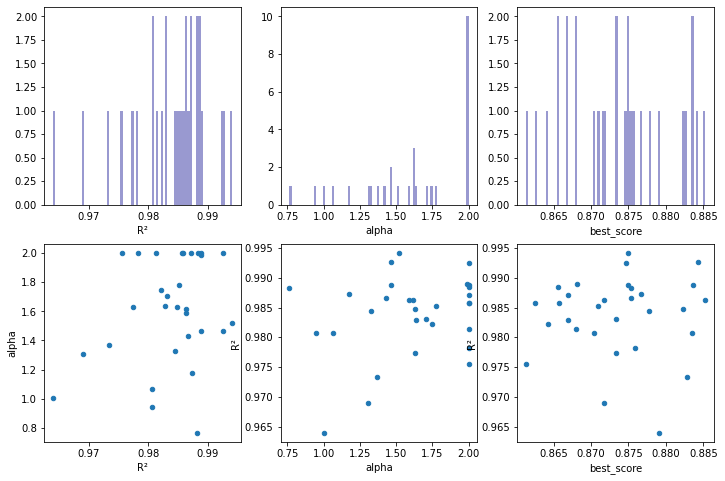

In [307]:
scrs = pd.DataFrame(scrs, columns=['R²', 'alpha', 'best_score'])
fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(2,3,1)
ax1 = fig.add_subplot(2,3,2)
ax2 = fig.add_subplot(2,3,3)
ax3 = fig.add_subplot(2,3,4)
ax4 = fig.add_subplot(2,3,5)
ax5 = fig.add_subplot(2,3,6)

sns.distplot(scrs['R²'], kde=False, bins=80, color='darkblue', ax=ax0)
plt.grid()
sns.distplot(scrs['alpha'], kde=False, bins=80, color='darkblue', ax=ax1)
sns.distplot(scrs['best_score'], kde=False, bins=80, color='darkblue', ax=ax2)

scrs.plot(kind='scatter', x='R²', y='alpha', ax=ax3)
scrs.plot(kind='scatter', x='alpha', y='R²', ax=ax4)
scrs.plot(kind='scatter', x='best_score', y='R²', ax=ax5)



In [308]:
coefs = ridge_cv.coef_

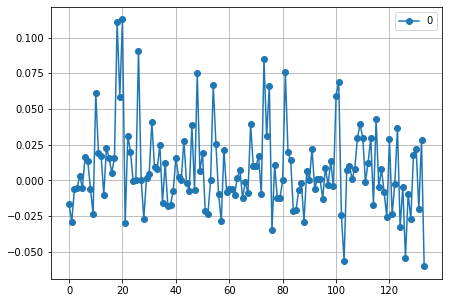

In [309]:
coefs_df = pd.DataFrame(coefs.ravel())
coefs_df.plot(marker='o', figsize=(7,5))
plt.xticks()
plt.grid()

### Here apperently relationships from the previous ridge regressions were exacerbated or reduced.which helps to highlight sectors who have more impact in the comercial energy consumption.

In [312]:
high_coefs = []
coefs_values = []

for i in range(len(coefs_df)):
    if np.abs(coefs.ravel()[i])>0.075:
        
        high_coefs.append(i)
        coefs_values.append(coefs.ravel()[i])


coefs_sorted = pd.DataFrame(coefs_values, index=x.iloc[:, high_coefs].columns).sort_values(by=0, ascending=False)

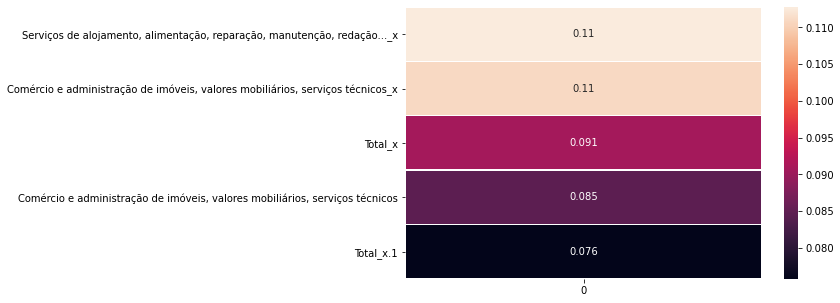

In [314]:
ax = plt.figure(figsize=(8,5))
ax0 = ax.add_subplot(111)
sns.heatmap(coefs_sorted, ax=ax0, annot=True, linewidths=0.5)


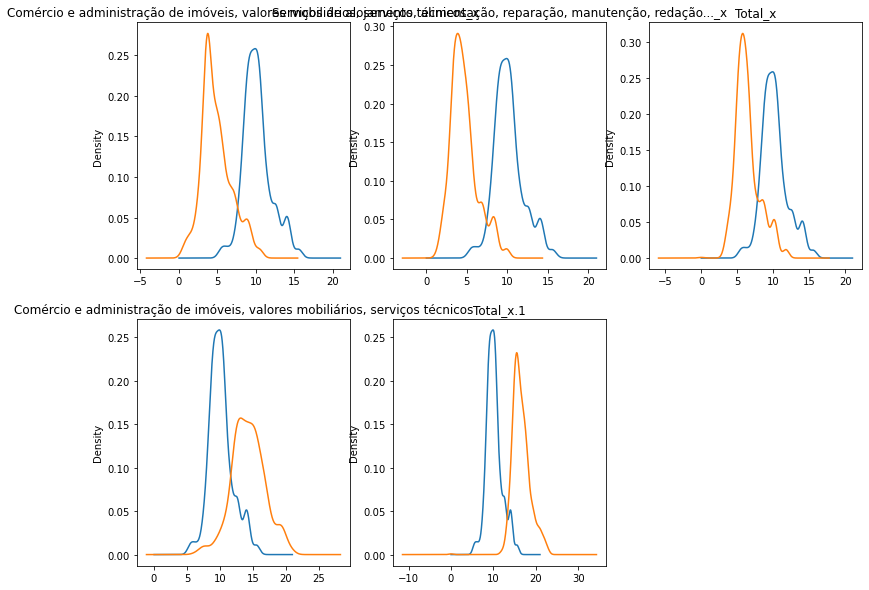

In [315]:
fig = plt.figure(figsize=(13, 10))

axes = [fig.add_subplot((len(high_coefs) if len(high_coefs)//3==0 else int(len(high_coefs)/3+1)), 3,  i+1) for i in range(len(high_coefs))]

for i in range(len(high_coefs)): 
    y[target].plot(kind='kde', ax=axes[i])
    x[x.columns[high_coefs[i]]].plot(kind='kde', ax=axes[i])
    axes[i].set_title(x.columns[high_coefs[i]])

#sns.kdeplot(y[target], ax=ax0)
#sns.kdeplot(x[x.columns[high_coefs[0]]], ax=ax0, bw=5) 

#y[target].plot(kind='kde', ax=ax0)
#x[x.columns[high_coefs[7]]].plot(kind='kde', ax=ax0)

# Lasso Cross-Validation

In [316]:
alphas = np.linspace(0.001, 5, 5000)

In [ ]:
 scrs = []
for i in range(50):
    
    msk = np.random.rand(len(y))<0.8
    x_train, y_train, x_test, y_test = x_norm[msk], y_norm[msk], x_norm[~msk], y_norm[~msk]

    lasso_cv = LassoCV(max_iter=5e4)

    lasso_cv.fit(x_train, y_train.ravel())

    #y_pred = lasso_cv.predict(x_test)

    y_pred = np.expm1(scaler.inverse_transform(lasso_cv.predict(x_test).reshape(-1, 1)))
    y_test = np.expm1(scaler.inverse_transform(y_test))

    scrs.append([r2_score(y_test, y_pred), lasso_cv.alpha_, lasso_cv.n_iter_])

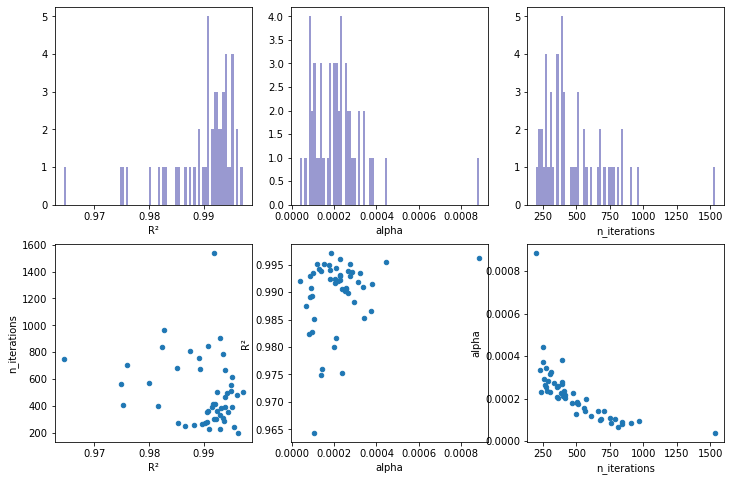

In [318]:
scrs = pd.DataFrame(scrs, columns=['R²', 'alpha', 'n_iterations'])
fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(2,3,1)
ax1 = fig.add_subplot(2,3,2)
ax2 = fig.add_subplot(2,3,3)
ax3 = fig.add_subplot(2,3,4)
ax4 = fig.add_subplot(2,3,5)
ax5 = fig.add_subplot(2,3,6)

sns.distplot(scrs['R²'], kde=False, bins=80, color='darkblue', ax=ax0)
plt.grid()
sns.distplot(scrs['alpha'], kde=False, bins=80, color='darkblue', ax=ax1)
sns.distplot(scrs['n_iterations'], kde=False, bins=80, color='darkblue', ax=ax2)

scrs.plot(kind='scatter', x='R²', y='n_iterations', ax=ax3)
scrs.plot(kind='scatter', x='alpha', y='R²', ax=ax4)
scrs.plot(kind='scatter', x='n_iterations', y='alpha', ax=ax5)



In [319]:
coefs = lasso_cv.coef_

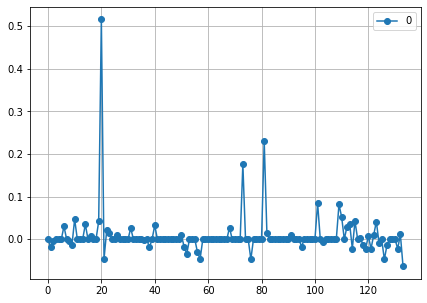

In [320]:
coefs_df = pd.DataFrame(coefs.ravel())
coefs_df.plot(marker='o', figsize=(7,5))
plt.xticks()
plt.grid()

In [321]:
high_coefs = []
coefs_values = []

for i in range(len(coefs_df)):
    if np.abs(coefs.ravel()[i])>0.07:
        
        high_coefs.append(i)
        coefs_values.append(coefs.ravel()[i])

coefs_sorted = pd.DataFrame(coefs_values, index=x.iloc[:, high_coefs].columns).sort_values(by=0, ascending=False)

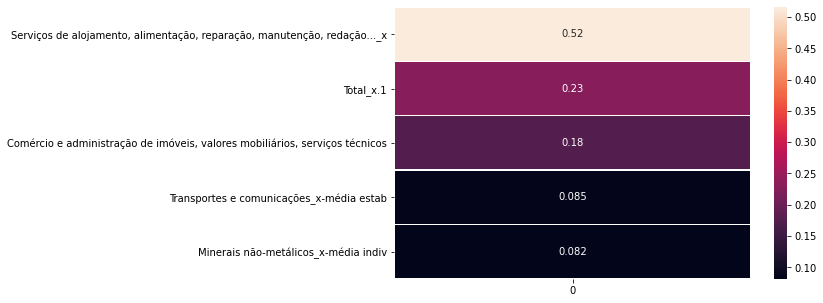

In [323]:
ax = plt.figure(figsize=(8,5))
ax0 = ax.add_subplot(111)
sns.heatmap(coefs_sorted, ax=ax0, annot=True, linewidths=0.5)


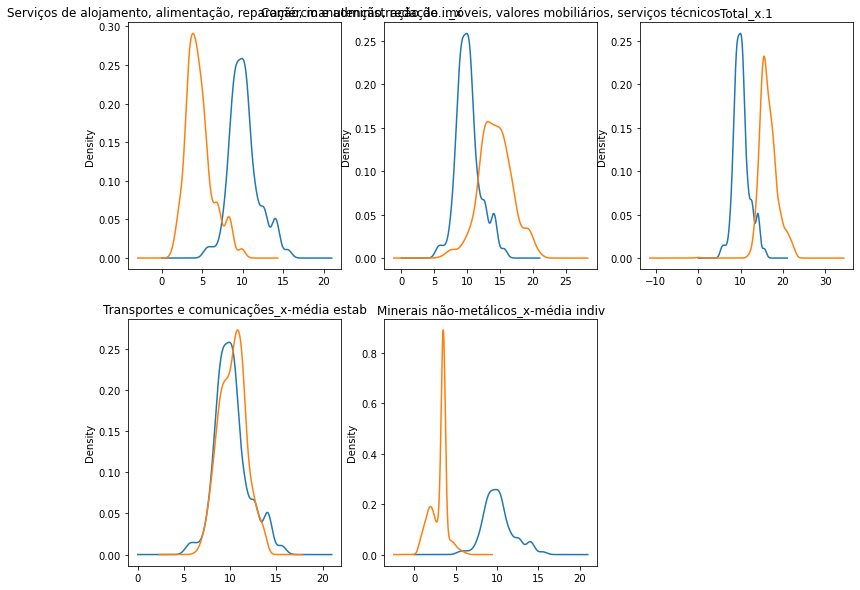

In [324]:
fig = plt.figure(figsize=(13, 10))

axes = [fig.add_subplot((len(high_coefs) if len(high_coefs)//3==0 else int(len(high_coefs)/3+1)), 3,  i+1) for i in range(len(high_coefs))]

for i in range(len(high_coefs)): 
    y[target].plot(kind='kde', ax=axes[i])
    x[x.columns[high_coefs[i]]].plot(kind='kde', ax=axes[i])
    axes[i].set_title(x.columns[high_coefs[i]])

#sns.kdeplot(y[target], ax=ax0)
#sns.kdeplot(x[x.columns[high_coefs[0]]], ax=ax0, bw=5) 

#y[target].plot(kind='kde', ax=ax0)
#x[x.columns[high_coefs[7]]].plot(kind='kde', ax=ax0)

#### Conclusion: Same Pattern from Lasso

# Elastic Net CV

In [325]:
from sklearn.linear_model import ElasticNetCV

In [326]:
msk = np.random.rand(len(y))<0.8
x_train, y_train, x_test, y_test = x_norm[msk], y_norm[msk], x_norm[~msk], y_norm[~msk]

In [327]:
elasticNetCV = ElasticNetCV(max_iter=1e4,
                            l1_ratio=np.linspace(1e2, 1e5, 51)).fit(x_train, y_train.ravel())

In [1673]:
#y_pred = elasticNetCV.predict(x_test)

In [328]:
y_pred = np.expm1(scaler.inverse_transform(elasticNetCV.predict(x_test).reshape(1, -1)))
y_test_b = np.expm1(scaler.inverse_transform(y_test))


In [329]:
r2_score(y_test_b.ravel(), y_pred.ravel())

0.9818975682475632

In [330]:
elasticNetCV.alpha_, elasticNetCV.l1_ratio_, elasticNetCV.n_iter_

(1.4476228290796677e-09, 100000.0, 344)

In [331]:
coefs = elasticNetCV.coef_

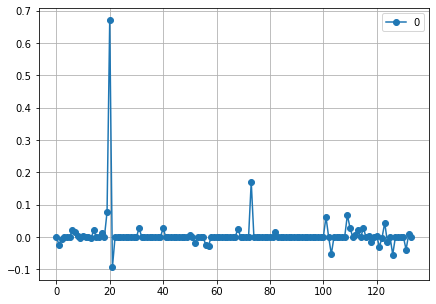

In [332]:
coefs_df = pd.DataFrame(coefs.ravel())
coefs_df.plot(marker='o', figsize=(7,5))
plt.xticks()
plt.grid()

In [333]:
high_coefs = []
coefs_values = []

for i in range(len(coefs_df)):
    if np.abs(coefs.ravel()[i])>0.05:
        
        high_coefs.append(i)
        coefs_values.append(coefs.ravel()[i])

coefs_sorted = pd.DataFrame(coefs_values, index=x.iloc[:, high_coefs].columns).sort_values(by=0, ascending=False)

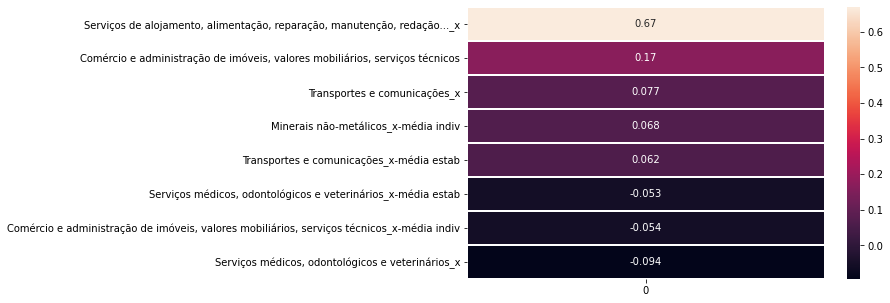

In [335]:
ax = plt.figure(figsize=(8,5))
ax0 = ax.add_subplot(111)
sns.heatmap(coefs_sorted, ax=ax0, annot=True, linewidths=0.5)


### We can see that less is paid in total with medical services in neighborhoods with high comercial energy consumption and more is paid per stablishment in the transport and communication sector

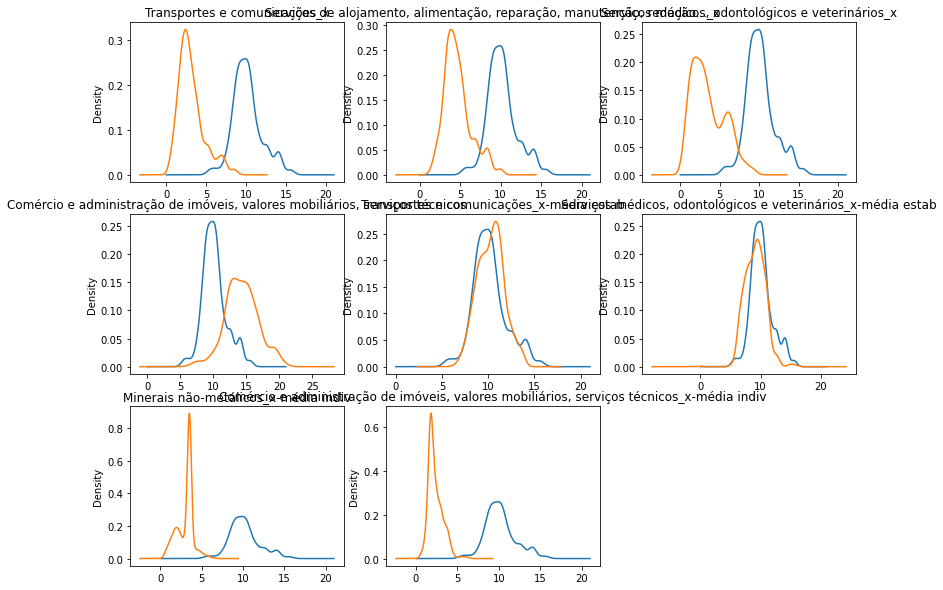

In [336]:
fig = plt.figure(figsize=(13, 10))

axes = [fig.add_subplot((len(high_coefs) if len(high_coefs)//3==0 else int(len(high_coefs)/3+1)), 3,  i+1) for i in range(len(high_coefs))]

for i in range(len(high_coefs)): 
    y[target].plot(kind='kde', ax=axes[i])
    x[x.columns[high_coefs[i]]].plot(kind='kde', ax=axes[i])
    axes[i].set_title(x.columns[high_coefs[i]])

#sns.kdeplot(y[target], ax=ax0)
#sns.kdeplot(x[x.columns[high_coefs[0]]], ax=ax0, bw=5) 

#y[target].plot(kind='kde', ax=ax0)
#x[x.columns[high_coefs[7]]].plot(kind='kde', ax=ax0)

# Sthocastic Gradient Descent

In [337]:
from sklearn.linear_model import SGDRegressor

In [338]:
msk = np.random.rand(len(y))<0.8
x_train, y_train, x_test, y_test = x_norm[msk], y_norm[msk], x_norm[~msk], y_norm[~msk]

In [340]:
model_parameters_dict = {
    'Linear': {'penalty': 'none'},
    'Lasso': {'penalty': 'l2',
           'alpha': lasso_cv.alpha_},
    'Ridge': {'penalty': 'l1',
           },
    'ElasticNet': {'penalty': 'elasticnet', 
                   'alpha': elasticNetCV.alpha_,
                   'l1_ratio': 0.01}
}

scrs = []

for modellabel, parameters in model_parameters_dict.items():
    # following notation passes the dict items as arguments
    SGD = SGDRegressor(eta0=0.02, **parameters)
    SGD.fit(x_train, y_train.ravel())
    scrs.append([modellabel, r2_score(y_test, SGD.predict(x_test))])


##  SGD Evaluation

In [341]:
scrs

[['Linear', 0.859324678264588],
 ['Lasso', 0.8740929509991269],
 ['Ridge', 0.8839931837931391],
 ['ElasticNet', 0.8830476091760137]]

In [342]:
model_parameters_dict

{'Linear': {'penalty': 'none'},
 'Lasso': {'penalty': 'l2', 'alpha': 0.00010733055633556548},
 'Ridge': {'penalty': 'l1'},
 'ElasticNet': {'penalty': 'elasticnet',
  'alpha': 1.4476228290796677e-09,
  'l1_ratio': 0.01}}

In [343]:
SGD.n_iter_, SGD.t_

(7, 5839.0)

In [344]:
coefs = SGD.coef_

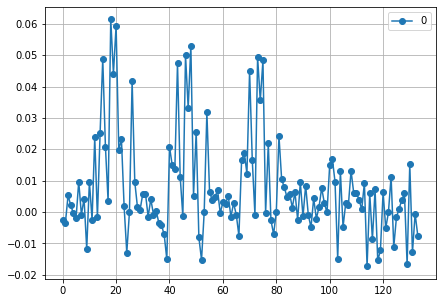

In [345]:
coefs_df = pd.DataFrame(coefs.ravel())
coefs_df.plot(marker='o', figsize=(7,5))
plt.xticks()
plt.grid()

In [348]:
high_coefs = []
coefs_values = []

for i in range(len(coefs_df)):
    if np.abs(coefs.ravel()[i])>0.04:
        
        high_coefs.append(i)
        coefs_values.append(coefs.ravel()[i])

coefs_sorted = pd.DataFrame(coefs_values, index=x.iloc[:, high_coefs].columns).sort_values(by=0, ascending=False)

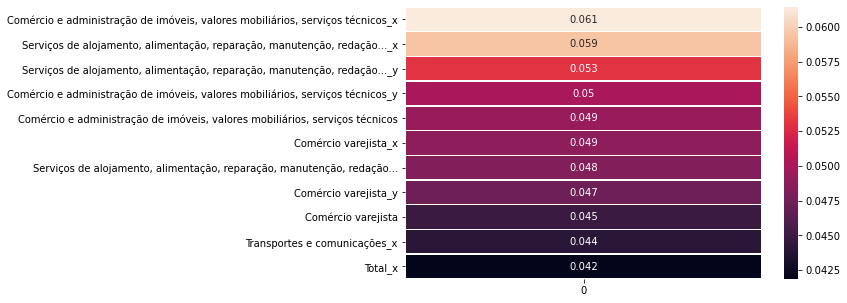

In [350]:
ax = plt.figure(figsize=(8,5))
ax0 = ax.add_subplot(111)
sns.heatmap(coefs_sorted, ax=ax0, annot=True, linewidths=0.5)


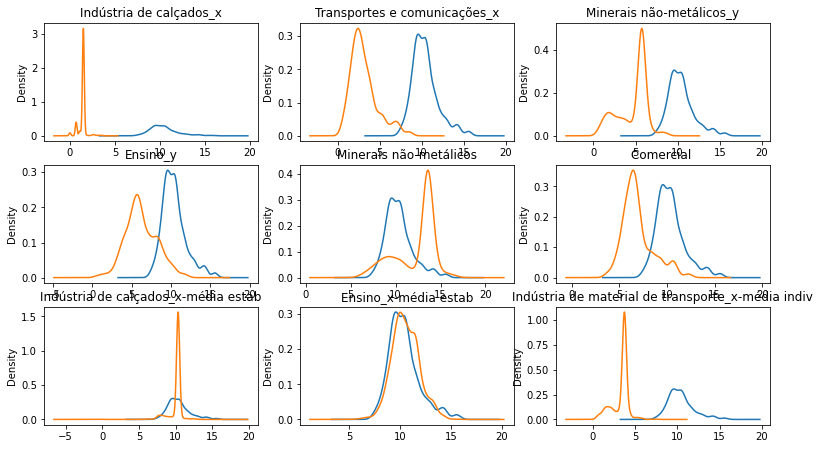

In [820]:
fig = plt.figure(figsize=(13, 10))

axes = [fig.add_subplot((len(high_coefs) if len(high_coefs)//3==0 else int(len(high_coefs)/3+1)), 3,  i+1) for i in range(len(high_coefs))]

for i in range(len(high_coefs)): 
    y[target].plot(kind='kde', ax=axes[i])
    x[x.columns[high_coefs[i]]].plot(kind='kde', ax=axes[i])
    axes[i].set_title(x.columns[high_coefs[i]])

#sns.kdeplot(y[target], ax=ax0)
#sns.kdeplot(x[x.columns[high_coefs[0]]], ax=ax0, bw=5) 

#y[target].plot(kind='kde', ax=ax0)
#x[x.columns[high_coefs[7]]].plot(kind='kde', ax=ax0)

### Conclusion: Neighborhoods associated with higher rural energy consumption have higher domestic energy consumption, higher public ilumination energy consumption, and interestingly, lower average individual salaries in the civil engineering sector. This means there is a tendency of higher rural energy consumption if the average salary paid in the civil engineering sector in that neighborhood is lower.